In [1]:
from word_extraction import PDF_Document

In [2]:
# Atiyah-Macdonald
data = "data/"
pdf_file = "pdf/hartshorne/Hartshorne_Algebraic_Geometry.pdf"

hartshorne = PDF_Document(pdf_file, data)

In [3]:
hartshorne.generate_word_data()

In [2]:
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from pathlib import Path

In [3]:
def img_to_array(img_file: str) -> np.array:
    """ Load image in as np.array.
    """
    image = Image.open(img_file).convert('L')
    w, h = image.size
    data = np.array(list(image.getdata()), dtype=np.uint8).reshape(h, w) # store values to numpy array
    return data

In [63]:
img = img_to_array("/home/luke/PDF_Word_Extraction/data/lorem_ipsum/page_0/sentence_0_1/words/word_0_1_13.png")

In [64]:
thing = Image.fromarray(img)

In [66]:
img.shape

(76, 259)

In [5]:
def letters_in_word(word: np.array) -> list[np.array]:
    """ Given a pixel array representing an image of a single word, we look for and extract the columns
    of pixels which represent letters in the word.
    """
    word = word.T
    word_h = word.shape[1]
    i = 0 
    letters = []
    while i < len(word) - 1:
        letter = []
        letter.append(word[i].reshape(word_h, 1))  # Reshape for hstack later
        j = i 
        while j < len(word) - 1:
            col1 = word[j]
            col2 = word[j + 1]

            col1_nonwhite = (col1 < 230).astype('int')
            col2_nonwhite = (col2 < 230).astype('int')

            if int(np.inner(col1_nonwhite, col2_nonwhite)) != 0:
                j += 1 
                letter.append(col2.reshape(word_h, 1))  # Reshape for hstack later
            else:
                break
        i += len(letter)
        if len(letter) > 2:  # Too small to be of any relevant detail to the eye
            letters.append(letter)

    letter_arrays = []
    for letter in letters:
        array = letter[0]
        for i in range(1, len(letter)):
            array = np.hstack((array, letter[i]))
        letter_arrays.append(array.astype('uint8'))
    return letter_arrays


In [46]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Loading and normalizing the data.
# Define transformations for the training and test sets
transformations = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10 dataset consists of 50K training images. We define the batch size of 10 to load 5,000 batches of images.
batch_size = 10
number_of_labels = 10 

# Create an instance for training. 
# When we run this code for the first time, the CIFAR10 train dataset will be downloaded locally. 
train_set = CIFAR10(root="./data",train=True,transform=transformations,download=True)

# Create a loader for the training set which will read the data within batch size and put into memory.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
print("The number of images in a training set is: ", len(train_loader)*batch_size)

# Create an instance for testing, note that train is set to False.
# When we run this code for the first time, the CIFAR10 test dataset will be downloaded locally. 
test_set = CIFAR10(root="./data", train=False, transform=transformations, download=True)

# Create a loader for the test set which will read the data within batch size and put into memory. 
# Note that each shuffle is set to false for the test loader.
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
print("The number of images in a test set is: ", len(test_loader)*batch_size)

print("The number of batches per epoch is: ", len(train_loader))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
The number of images in a training set is:  50000
Files already downloaded and verified
The number of images in a test set is:  10000
The number of batches per epoch is:  5000


In [4]:
import matplotlib.pyplot as plt

In [47]:
image, label = iter(train_loader).next()

In [48]:
image[0].shape

torch.Size([3, 32, 32])

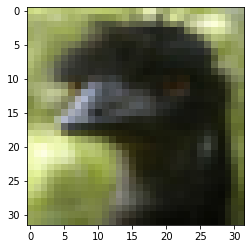

In [61]:
plt.imshow(image[9].permute(1, 2, 0))

In [118]:
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform

from pathlib import Path
import pandas as pd
import torch

letters = [ 
"a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z",
"A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z",
]

def get_letter_ind(letter):
    for idx, symbol in enumerate(letters):
        if symbol == letter:
            return idx 
    print(f"Could not find index of {letter=}")
    return None



class LetterDataset(Dataset):
    """Letter dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """ 
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.letters_frame = pd.read_csv(csv_file)
        self.root_dir = Path(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.letters_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.letters_frame.iloc[idx, 0]
        image = io.imread(img_name)
        letter = self.letters_frame.iloc[idx, 1] 
        letter_ind = get_letter_ind(letter)
        letter_vec = np.zeros(len(letters))
        letter_vec[letter_ind] = 1 
        sample = {"image": image, "letter": letter_vec}
            
        if self.transform:
            sample = self.transform(sample["image"])

        return sample


In [119]:
letter_dataset = LetterDataset("data/letters/labels.csv", "asdas")

In [94]:
b = a[4]

In [95]:
b["image"].shape

(59, 57)

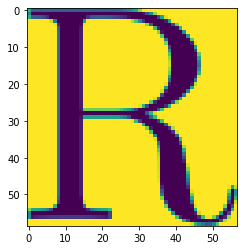

In [96]:
plt.imshow(b["image"])

In [6]:
import torch
from skimage import transform


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'letter': sample["letter"]}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        if h - new_h <= 0:
            print(f"input shape is ({h=}, {w=})")
            print(f"h - new_h <=0, {h=}, {new_h=}")

        if w - new_w <= 0:
            print(f"input shape is ({h=}, {w=})")
            print(f"w - new_w <=0, {w=}, {new_w=}")
            
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'letter': sample["letter"]}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, letter = sample['image'], sample['letter']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'letter': torch.from_numpy(letter)}


In [118]:
scale = Rescale((70,70))
crop = RandomCrop((50,50))
composed = transforms.Compose([scale, crop])

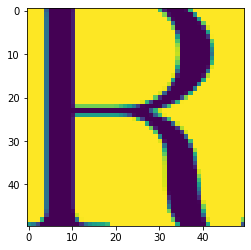

In [119]:
plt.imshow(crop(sample)["image"])

input shape is (h=75, w=55)
w - new_w <=0, w=55, new_w=60


ValueError: high <= 0

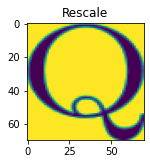

In [141]:
scale = Rescale((70,70))
crop = RandomCrop((60,60))
composed = transforms.Compose([scale,crop])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = letter_dataset[6]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample["image"])

plt.show()


In [164]:
from torchvision.transforms import CenterCrop, Pad
a = Pad(10, fill=255)

In [168]:
sample["image"].shape

(75, 55)

In [169]:
b = a(torch.from_numpy(sample["image"]))

In [170]:
b.shape

torch.Size([95, 75])

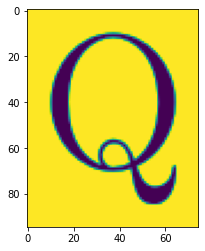

In [171]:
plt.imshow(b)

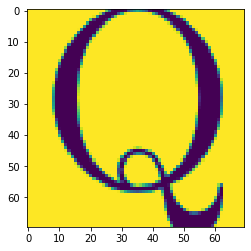

In [172]:
c = CenterCrop((70, 70))
d = c(b)
plt.imshow(d)

In [173]:
d.shape

torch.Size([70, 70])

1 73 19
8 71 38
10 76 37
17 54 38
19 74 34
20 54 28
25 88 20
27 54 36
34 52 28
35 51 31
36 54 31
37 54 32
45 72 24
46 68 26
49 74 27
51 71 18


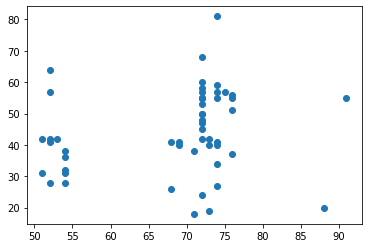

In [261]:
x_data = []
y_data = []

for i in range(len(letter_dataset)):
    img = letter_dataset[i]["image"]
    x = img.shape[0]
    y = img.shape[1]
    
    x_data.append(x)
    y_data.append(y)
    
    if x < 40 or y < 40:
        print(i, x, y)n
    
plt.plot(x_data, y_data, 'o')

1 59 19
7 39 42
8 57 38
9 37 42
10 62 37
14 38 42
17 39 38
19 60 34
20 39 28
25 74 20
26 38 41
27 39 36
30 38 64
32 38 57
34 38 28
35 37 31
36 39 31
37 39 32
45 58 24
46 53 26
49 60 27
51 57 18


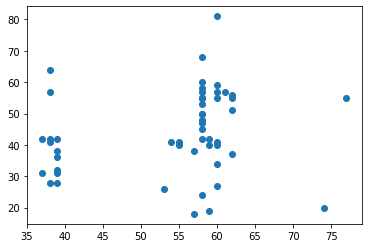

In [98]:
x_data = []
y_data = []

for i in range(len(letter_dataset)):
    img = letter_dataset[i]["image"]
    x = img.shape[0]
    y = img.shape[1]
    
    x_data.append(x)
    y_data.append(y)
    
    if x < 40 or y < 40:
        print(i, x, y)
    
plt.plot(x_data, y_data, 'o')

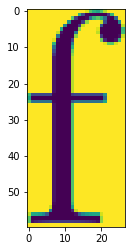

In [99]:
plt.imshow(letter_dataset[49]["image"])

In [120]:
import math
from torchvision.transforms import Pad, CenterCrop

class CustomPad:
    def __init__(self, output_size: tuple[float, float]):
        self.output_size = output_size
        

    def __call__(self, image):
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        left_pad = 0
        top_pad = 0
        right_pad = 0
        bottom_pad = 0

        if (horiz_pad := new_w - w) > 0:
            left_pad = math.ceil(horiz_pad / 2) 
            right_pad = math.floor(horiz_pad / 2) 
            
        if (vertical_pad := new_h - h) > 0:
            top_pad = math.ceil(vertical_pad / 2) 
            bottom_pad = math.floor(vertical_pad / 2) 
            
        padding = Pad((left_pad, top_pad, right_pad, bottom_pad), fill=255)
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image)
        image = padding(image)
        
        return image
        
class CustomCenterCrop:
    def __init__(self, output_size: tuple[float, float]):
        self.output_size = output_size
        self.torch_center_crop = CenterCrop(output_size)

    def __call__(self, image):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image)
        
        image = self.torch_center_crop(image)
        return image       

In [169]:
from torchvision import transforms, utils

trans = transforms.Compose([
CustomPad((100, 100)),
#CustomCenterCrop((90, 90)),
transforms.RandomCrop((80, 80))
])

letter_dataset = LetterDataset("data/letters/labels.csv", "asdas", trans)

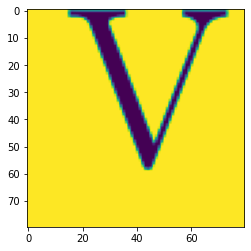

In [191]:
plt.imshow(letter_dataset[13])

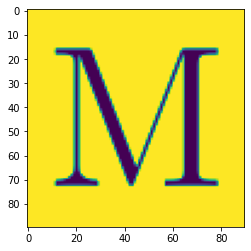

In [127]:
plt.imshow(letter_dataset[48])

In [48]:
img = img_to_array("/home/luke/PDF_Word_Extraction/data/letters/j/page_0.png")


In [78]:
def sentences_in_page(page: np.array) -> list[np.array]:
    """ Given a pixel array representing an image of a single page, we return a list of pixel arrays,
    obtained from the image of the page, which represent the sentences in the page.
    """
    row_ind = 0
    sentences = []
    while row_ind < len(page) - 1:
        sentence = []
        row = page[row_ind].reshape(1, len(page[row_ind]))  # reshape for vstack
        sentence.append(row)
        j = row_ind
        while j < len(page) - 1:  # -1 since we grab two rows at a time
            row1 = page[j].reshape(1, len(page[j]))
            row2 = page[j + 1].reshape(1, len(page[j + 1]))

            # We now examine what pixels in the rows are nonwhite
            row1_nonwhite = (row1 < 230).astype("int")  # Cast bool values to 1s and 0s
            row2_nonwhite = (row2 < 230).astype("int")
            # Take their dot product and check if it's zero; it's nonzero if we're scanning a set of letters.
            rows_are_nonwhite = np.inner(row1_nonwhite, row2_nonwhite) != 0
            if np.inner(row1_nonwhite, row2_nonwhite) != 0 or ((np.sum(page[j:j+15] < 255) > 0) and len(sentence) > 1):
                print(f"{rows_are_nonwhite=} and {len(sentence)=}")
                sentence.append(row2)
                j += 1
            else:
                break
        row_ind += len(sentence)
        if len(sentence) > 2:
            sentences.append(sentence)

    sentence_arrays = []
    # We now stack our rows of pixel data to create sentences, and return the list of sentences.
    for sentence in sentences:
        array = sentence[0]
        for row_ind in range(1, len(sentence)):
            array = np.vstack((array, sentence[row_ind]))
        sentence_arrays.append(array.astype('uint8'))
    return sentence_arrays

In [79]:
a = sentences_in_page(img)
b = words_in_sentence(a[0])
c = letters_in_word(b[0])

rows_are_nonwhite=array([[ True]]) and len(sentence)=1
rows_are_nonwhite=array([[ True]]) and len(sentence)=2
rows_are_nonwhite=array([[ True]]) and len(sentence)=3
rows_are_nonwhite=array([[ True]]) and len(sentence)=4
rows_are_nonwhite=array([[ True]]) and len(sentence)=5
rows_are_nonwhite=array([[ True]]) and len(sentence)=6
rows_are_nonwhite=array([[ True]]) and len(sentence)=7
rows_are_nonwhite=array([[ True]]) and len(sentence)=8
rows_are_nonwhite=array([[False]]) and len(sentence)=9
rows_are_nonwhite=array([[False]]) and len(sentence)=10
rows_are_nonwhite=array([[False]]) and len(sentence)=11
rows_are_nonwhite=array([[False]]) and len(sentence)=12
rows_are_nonwhite=array([[False]]) and len(sentence)=13
rows_are_nonwhite=array([[False]]) and len(sentence)=14
rows_are_nonwhite=array([[False]]) and len(sentence)=15
rows_are_nonwhite=array([[False]]) and len(sentence)=16
rows_are_nonwhite=array([[False]]) and len(sentence)=17
rows_are_nonwhite=array([[False]]) and len(sentence)=18
r

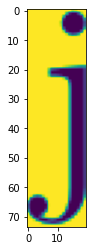

In [80]:
plt.imshow(c[0])